# 0. ML/DL 파이프라인

1. 해결할 문제 정의

2. 데이터 수집

3. 데이터 가공: 전처리

4. 딥러닝 모델 설계

5. 딥러닝 모델 학습

6. 성능 평가

# 1. 해결할 문제 정의 & 2. 데이터 수집



- WAGRALLE-DEEP-LEARNING-FROM-SCRATCH 폴더에 project 하위 폴더를 생성합니다.

- project 폴더 안에 `Projects_example.ipynb` 파일을 이동시킵니다.

- Extensions에서 Jupyter를 설치합니다.

- project 폴더 안에 dataset 하위 폴더를 생성합니다. 

- Kaggle에서 데이터셋을 다운로드합니다.

    - 링크: [https://www.kaggle.com/datasets/sumithsingh/blood-cell-images-for-cancer-detection](https://www.kaggle.com/datasets/sumithsingh/blood-cell-images-for-cancer-detection)

    - 아까 생성한 dataset 폴더에 압축을 풉니다.

    - basophil, erythroblast, monocyte, myeloblast, seg_neutrophil 폴더가 있음을 확인합니다.

- 터미널을 열고, 다음 코드를 입력합니다.

    - `pip install opencv-python`

    - `pip install scikit-learn`

# 3. 데이터 가공: 전처리

In [3]:
# 데이터셋 로드하기
import os
import cv2
import numpy as np

def load_dataset(dataset_path, img_size=(64, 64)):
    data = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))  # 클래스 이름 정렬
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            # 이미지를 읽고 크기 조정
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # RGB로 강제 읽기
            img = cv2.resize(img, img_size)
            if len(img.shape) == 2:  # 채널 정보가 없으면
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # 흑백을 RGB로 변환
            data.append(img / 255.0)  # 정규화
            labels.append(class_idx)
    return np.array(data), np.array(labels), class_names

dataset_path = r"C:\Users\gildo\Desktop\WegraLee-deep-learning-from-scratch\project\dataset" # 자신의 데이터셋 경로를 입력 
data, labels, class_names = load_dataset(dataset_path)
print(f"데이터셋 크기: {data.shape}, 레이블 크기: {labels.shape}")

데이터셋 크기: (5000, 64, 64, 3), 레이블 크기: (5000,)


In [6]:
# 클래스 이름과 라벨 번호 출력
for idx, class_name in enumerate(class_names):
    print(f"라벨 {idx}: {class_name}")

라벨 0: basophil
라벨 1: erythroblast
라벨 2: monocyte
라벨 3: myeloblast
라벨 4: seg_neutrophil


In [7]:
# 클래스별 데이터 개수 출력
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique, counts))

print("클래스별 데이터 개수:")
for class_idx, count in class_counts.items():
    print(f"{class_names[class_idx]}: {count}개")

클래스별 데이터 개수:
basophil: 1000개
erythroblast: 1000개
monocyte: 1000개
myeloblast: 1000개
seg_neutrophil: 1000개


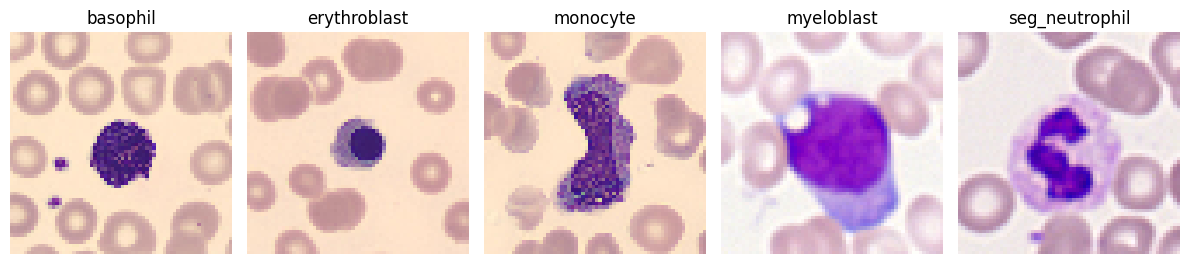

In [8]:
import matplotlib.pyplot as plt

# 클래스별 대표 이미지 출력
plt.figure(figsize=(12, 6))
for class_idx, class_name in enumerate(class_names):
    # 해당 클래스의 첫 번째 이미지 가져오기
    sample_idx = np.where(labels == class_idx)[0][0]
    sample_image = data[sample_idx]

    # 데이터를 [0, 255]로 변환 후 uint8 형식으로 변환
    sample_image_uint8 = (sample_image * 255).astype(np.uint8)

    # 이미지 시각화
    plt.subplot(1, len(class_names), class_idx + 1)
    plt.imshow(cv2.cvtColor(sample_image_uint8, cv2.COLOR_BGR2RGB))  # OpenCV 이미지는 BGR이므로 RGB로 변환
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

# Train/Test 데이터 분리
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train 데이터 크기: {train_data.shape}, {train_labels.shape}")
print(f"Test 데이터 크기: {test_data.shape}, {test_labels.shape}")

Train 데이터 크기: (4000, 64, 64, 3), (4000,)
Test 데이터 크기: (1000, 64, 64, 3), (1000,)


# 4. 딥러닝 모델 설계 & 5. 모델 학습 & 6. 성능 평가

## MLP

In [12]:
# 데이터 Flatten

train_data_flat = train_data.reshape(train_data.shape[0], -1)
test_data_flat = test_data.reshape(test_data.shape[0], -1)

print(f"Flattened Train 데이터 크기: {train_data_flat.shape}")
print(f"Flattened Test 데이터 크기: {test_data_flat.shape}")

Flattened Train 데이터 크기: (4000, 12288)
Flattened Test 데이터 크기: (1000, 12288)


In [13]:
# 원-핫 인코딩 함수
def one_hot_encode(labels, num_classes):
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

# train_labels와 test_labels 처리
num_classes = len(class_names)
train_labels = one_hot_encode(train_labels.astype(int), num_classes)
test_labels = one_hot_encode(test_labels.astype(int), num_classes)

print(f"Train 레이블 크기: {train_labels.shape}")
print(f"Test 레이블 크기: {test_labels.shape}")

Train 레이블 크기: (4000, 5)
Test 레이블 크기: (1000, 5)


In [15]:
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

Iter 0, Loss: 1.6149205020740123, Train Accuracy: 0.20125, Test Accuracy: 0.201
Iter 125, Loss: 1.6009439900335636, Train Accuracy: 0.23575, Test Accuracy: 0.234
Iter 250, Loss: 1.5914749782614996, Train Accuracy: 0.35825, Test Accuracy: 0.355
Iter 375, Loss: 1.5781852268517653, Train Accuracy: 0.51025, Test Accuracy: 0.493
Iter 500, Loss: 1.5526791330821785, Train Accuracy: 0.43475, Test Accuracy: 0.428
Iter 625, Loss: 1.538939087695169, Train Accuracy: 0.5175, Test Accuracy: 0.515
Iter 750, Loss: 1.5035461004244317, Train Accuracy: 0.61125, Test Accuracy: 0.619
Iter 875, Loss: 1.392863400263056, Train Accuracy: 0.5545, Test Accuracy: 0.541
Iter 1000, Loss: 1.3555447174421689, Train Accuracy: 0.513, Test Accuracy: 0.507
Iter 1125, Loss: 1.2205486282474454, Train Accuracy: 0.5095, Test Accuracy: 0.51
Iter 1250, Loss: 1.2144760759073963, Train Accuracy: 0.599, Test Accuracy: 0.596
Iter 1375, Loss: 1.0748634806595156, Train Accuracy: 0.627, Test Accuracy: 0.633
Iter 1500, Loss: 1.0007801

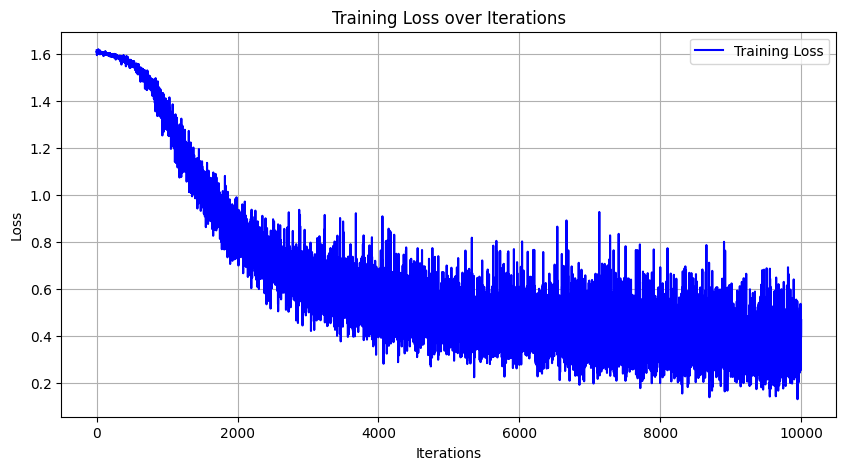

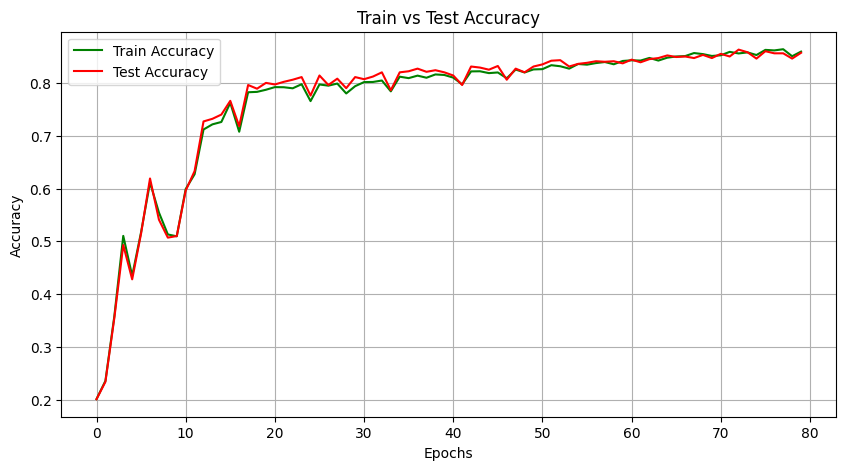

In [16]:
import matplotlib.pyplot as plt

# 모델 초기화
input_size = train_data_flat.shape[1]  # 12288 (Flatten된 데이터 크기)
hidden_size = 50  # 은닉층 크기
output_size = 5  # 클래스 개수 (5)

network = TwoLayerNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# 학습 하이퍼파라미터
iters_num = 10000  # 학습 반복 횟수
batch_size = 32  # 배치 크기
learning_rate = 0.001  # 학습률

# 학습 과정 기록용
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 에포크 계산
train_size = train_data_flat.shape[0] # 4000
iter_per_epoch = max(train_size // batch_size, 1) # 4000//32 = 125
# total_epochs = iters_num // iter_per_epoch = 10000 // 125 = 80

# 학습 루프
for i in range(iters_num):
    # Mini-batch 추출
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = train_data_flat[batch_mask]
    t_batch = train_labels[batch_mask]

    # 기울기 계산 (오차 역전파)
    grads = network.gradient(x_batch, t_batch)

    # 파라미터 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grads[key]

    # 손실 계산 및 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1 에포크마다 결과 출력
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(train_data_flat, train_labels)
        test_acc = network.accuracy(test_data_flat, test_labels)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"Iter {i}, Loss: {loss}, Train Accuracy: {train_acc}, Test Accuracy: {test_acc}")

# 최종 Test 데이터 평가
test_acc = network.accuracy(test_data_flat, test_labels)
print(f"Final Test Accuracy: {test_acc}")

# 손실 함수 그래프 (Loss)
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label="Training Loss", color="blue")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss over Iterations")
plt.legend()
plt.grid()
plt.show()

# 정확도 그래프 (Train / Test Accuracy)
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label="Train Accuracy", color="green")
plt.plot(test_acc_list, label="Test Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid()
plt.show()

- loss 값이 감소함

- train과 test accuracy 값 모두 epoch가 지남에 따라 증가함. 둘의 차이가 크지 않은 것으로 보어 과적합(overfitting)이 잘 억제됨. 

## CNN 

In [17]:
# 데이터 차원 재배치 (N, C, H, W 형태로 변환)
train_data = train_data.transpose(0, 3, 1, 2)  # (N, H, W, C) → (N, C, H, W)
test_data = test_data.transpose(0, 3, 1, 2)    # (N, H, W, C) → (N, C, H, W)

print(f"Train 데이터 크기: {train_data.shape}")
print(f"Test 데이터 크기: {test_data.shape}")

Train 데이터 크기: (4000, 3, 64, 64)
Test 데이터 크기: (1000, 3, 64, 64)


In [20]:
# coding: utf-8
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
from common.trainer import Trainer

class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:1.5779012091485631
=== epoch:1, train acc:0.194, test acc:0.2 ===
train loss:1.544770691724087
train loss:1.6540540464519418
train loss:1.5921935760445516
train loss:1.6100065105592674
train loss:1.606945893025215
train loss:1.5945781644884498
train loss:1.5889790277912097
train loss:1.5982029539415086
train loss:1.606018138782906
train loss:1.5902561762688547
train loss:1.5909228998285934
train loss:1.5846343737393491
train loss:1.575294680147749
train loss:1.5828047828401695
train loss:1.5537921702256905
train loss:1.5535153558724888
train loss:1.5288174852103051
train loss:1.5369961420098641
train loss:1.5272816464003203
train loss:1.4994194867761526
train loss:1.4868171101873073
train loss:1.41189604485341
train loss:1.4732860473601173
train loss:1.4416719806293166
train loss:1.5060061754389331
train loss:1.5135700800268381
train loss:1.4026602173574878
train loss:1.4101892503852027
train loss:1.3948722490477479
train loss:1.3370590314178057
train loss:1.3350251838379994

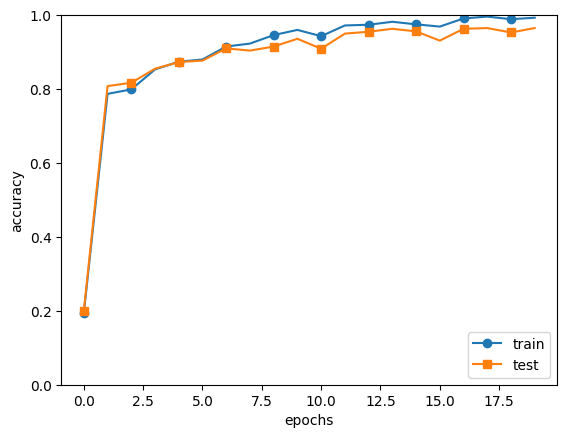

In [22]:
# 학습 하이퍼파라미터
max_epochs = 20  # 학습 에포크 수
batch_size = 32  # 배치 크기
learning_rate = 0.001  # 학습률

# CNN 모델 초기화
input_dim = (3, 64, 64)  # 입력 데이터 크기 (채널, 높이, 너비)
conv_param = {'filter_num': 64, 'filter_size': 3, 'pad': 1, 'stride': 1}  # 합성곱 계층 파라미터
hidden_size = 100  # 은닉층 크기
output_size = len(class_names)  # 클래스 개수

network = SimpleConvNet(input_dim=input_dim, 
                        conv_param=conv_param, 
                        hidden_size=hidden_size, 
                        output_size=output_size, 
                        weight_init_std=0.01)

trainer = Trainer(network, train_data, train_labels, test_data, test_labels,
                  epochs=max_epochs, mini_batch_size=batch_size,
                  optimizer='Adam', optimizer_param={'lr': learning_rate},
                  evaluate_sample_num_per_epoch=1000)

# 학습 실행
# 1~2시간 정도 소요됨 
trainer.train()

# 모델 저장
network.save_params("cnn_params.pkl")
print("Saved Network Parameters!")

# 학습 결과 시각화
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- test accuracy가 0.972로, 이전 MLP의 값인 0.864보다 훨씬 크게 향상했음을 확인할 수 있다!